In [1]:
import pandas as pd

In [3]:
import seaborn as sns

In [4]:
import numpy as np

In [7]:
from matplotlib import pyplot as plt

In [9]:
fpath = 'data/prep/'
dfile = 'form_data_v2.0.csv'

In [11]:
df = pd.read_csv( fpath + dfile, header=0, parse_dates=True )

In [12]:
# flat races
df = df[df.Type.isna()]

In [13]:
# remove entries with missing Draw - some of these could be imputed or manually entered
# print(df.RaceId[df.Draw.isna()].unique())
df = df[~df.Draw.isna()]

In [14]:
# no. declared, ie FieldSize + RR + withdrawn
DeclFieldSize = df[['RaceId', 'Draw']].groupby('RaceId').max().squeeze().rename('DeclFieldSize').astype(int)

In [15]:
df = df.join(DeclFieldSize, on='RaceId')

In [16]:
# replace non-numeric Posn with last place and cast to int TODO
# df[~df.Posn.str.isnumeric(), 'Posn'] = df[~df.Posn.str.isnumeric(), 'DeclFieldSize']
df['Posn'] = df.apply(lambda r: int(r.Posn) if r.Posn.isnumeric() else r.DeclFieldSize, axis=1)

In [42]:
def xmast(data, course_name, dist, min_ave_supp=3):
    dat = data[(data.CourseName==course_name) & (data.Distance==dist)]
    # TODO filter on distance (m,f,y) , going
    dat = pd.DataFrame({'FieldSize': dat.DeclFieldSize, 
                        'Draw': dat.Draw.apply(int),
                        # TODO index options as argument
                        'Index': dat.Won
                       })
    # TODO add other indexes as (string) options
    # create tables
    g = dat[['FieldSize','Draw','Index']].groupby(['FieldSize','Draw'])
    dat_sum = g.sum()
    dat_n = g.count()
    dat_sum = dat_sum.reset_index().pivot_table(index='FieldSize',columns='Draw').fillna(0)
    dat_n = dat_n.reset_index().pivot_table(index='FieldSize',columns='Draw').fillna(0)
    dat_sum.columns = dat_sum.columns.droplevel(0)
    dat_n.columns = dat_n.columns.droplevel(0)
    # aggregate to min_ave_supp
    min_fieldsize = dat_n.index.values.min()
    max_draw = dat_n.columns.values.max()
    dat_0 = pd.DataFrame(np.zeros([max_draw, max_draw]), index=np.arange(1,max_draw+1), columns=np.arange(1,max_draw+1))    
    dat_sum = (dat_sum + dat_0).fillna(0)
    dat_n = (dat_n  + dat_0).fillna(0) # NB. loses index name 'FieldSize'    
    # # debugging
    dat_n_0 = dat_n.copy()
    dat_sum_0 = dat_sum.copy()
    dat_n = dat_n_0.copy()
    dat_sum = dat_sum_0.copy()
    row_idx = 0
    
    while ~np.all(dat_n.sum(axis=1) / dat_n.index.values >= min_ave_supp):
        # aggregate from top or bottom ?
        a = dat_n.index[dat_n.sum(axis=1) / dat_n.index.values < min_ave_supp].values
        row_idx = int(sum(a < len(dat_n)/2) > len(a)/2) - 1
        # # debugging
        # print(dat_n.sum(axis=1) / dat_n.index.values >= min_ave_supp)
        # print(row_idx)
        # print()
        vec1_n = dat_n.iloc[row_idx,:dat_n.index[row_idx]].values
        vec1_sum = dat_sum.iloc[row_idx,:dat_sum.index[row_idx]].values
        if row_idx == -1:
            # downsample last
            sample_mat = 1 / (len(vec1_n)-1) * \
                            (np.concatenate( [np.diag(np.arange(len(vec1_n)-1,0,-1)), np.zeros([len(vec1_n)-1,1]) ], axis=1) + \
                            np.concatenate( [np.zeros([len(vec1_n)-1,1]), np.diag(np.arange(1,len(vec1_n),1)) ], axis=1))
            vec2_n = np.matmul(sample_mat, vec1_n)
            vec2_sum = np.matmul(sample_mat, vec1_sum)
            # add to previous
            dat_n.iloc[row_idx-1,:len(vec2_n)] = dat_n.iloc[row_idx-1,:len(vec2_n)] + vec2_n
            dat_sum.iloc[row_idx-1,:len(vec2_sum)] = dat_sum.iloc[row_idx-1,:len(vec2_sum)] + vec2_sum
            # drop last row and column
            dat_n = dat_n.drop(index=dat_n.index[row_idx]).drop(columns=dat_n.columns[row_idx])
            dat_sum = dat_sum.drop(index=dat_sum.index[row_idx]).drop(columns=dat_sum.columns[row_idx])
        else:
            # upsample first
            sample_mat = 1 / (len(vec1_n)+1) * \
                            (np.concatenate( [np.diag(np.arange(len(vec1_n),0,-1)), np.zeros([1,len(vec1_n)]) ], axis=0) + \
                            np.concatenate( [np.zeros([1,len(vec1_n)]), np.diag(np.arange(1,len(vec1_n)+1,1)) ], axis=0))
            vec2_n = np.matmul(sample_mat, vec1_n)
            vec2_sum = np.matmul(sample_mat, vec1_sum)
            # add to next
            dat_n.iloc[row_idx+1,:len(vec2_n)] = dat_n.iloc[row_idx+1,:len(vec2_n)] + vec2_n
            dat_sum.iloc[row_idx+1,:len(vec2_sum)] = dat_sum.iloc[row_idx+1,:len(vec2_sum)] + vec2_sum
            # drop first row
            dat_n = dat_n.drop(index=dat_n.index[row_idx])
            dat_sum = dat_sum.drop(index=dat_sum.index[row_idx])
    # center non-zero values for heatmap
    i2 = dat_sum.index.values
    n_draw = dat_sum.shape[1]
    i1 = (n_draw - i2)//2

    dat_sum_np = dat_sum.to_numpy()
    dat_n_np = dat_n.to_numpy()
    hm_dat_sum_np = np.zeros(dat_sum_np.shape)
    hm_dat_n_np = np.zeros(dat_n_np.shape)

    for i in range(hm_dat_sum_np.shape[0]):
        hm_dat_sum_np[ i, i1[i]:(i1[i]+i2[i]) ] = dat_sum_np[ i, :i2[i]] 
        hm_dat_n_np[ i, i1[i]:(i1[i]+i2[i]) ] = dat_n_np[ i, :i2[i]]
            
    # hm_data = pd.DataFrame(hm_dat_sum_np / hm_dat_n_np, # div by zero
    hm_data = pd.DataFrame(np.divide(hm_dat_sum_np, hm_dat_n_np, where=hm_dat_n_np>0, out=np.zeros(hm_dat_sum_np.shape)),
                            index=dat_sum.index.rename('FieldSize'),
                            columns=dat_sum.columns.rename('Draw (low to high, centered)'))
    # normalize the rows
    # TODO this is messy and loses the index and label
    hm_data = hm_data.reset_index().apply(lambda r: r[1:]/sum(r[1:])*r.FieldSize, axis=1)
    hm_annot = pd.DataFrame(np.round(np.log(hm_dat_n_np+1)).astype(int).astype(str),
                            index=dat_sum.index.rename('FieldSize'),
                            columns=dat_sum.columns.rename('Draw (low to high, centered)')).replace('0','')
    # return (hm_data, hm_annot)
    return (hm_data, hm_annot)


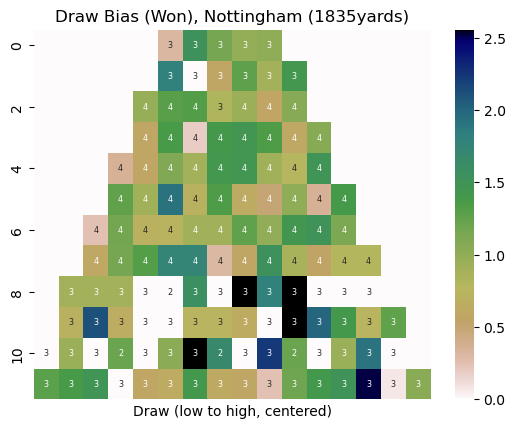

In [54]:
%matplotlib inline
course_name = 'Nottingham'
dist = 8*220 + 75
# course_name = 'Newmarket'
# course_name = 'Goodwood'
# course_name = 'Haydock'
min_ave_supp = 10

plt.figure()
plt.title('Draw Bias (Won), ' + course_name + ' (' + str(dist) + 'yards)')
hm_data, hm_annot = xmast(df, course_name, dist, min_ave_supp)

# TODO fix hm_data.index for correct y-axis (FieldSize) label and ticklabels
sns.heatmap(hm_data,
    cmap='gist_earth_r', robust=True,
    annot=hm_annot, fmt='', annot_kws={'fontsize': 'xx-small'},
    xticklabels=False, yticklabels=2
    )
plt.show()
# plt.savefig('xmast_' + course_name + '.png')
plt.close()

In [278]:
df

,RaceId,CourseName,RaceDate,RaceTime,Type,Class,Prize,FieldSize,Distance,RaceWinTime,...,AgeMin,AgeMax,AW,Going1,Going1N,Won,Placed,ReturnWin,ReturnPlace,DeclFieldSize
365,42370140,Southwell,2016-01-01,12:20:00,NaN,5.0,3234.0,8,1760,102.43,...,4.0,NaN,False,standard,3.0,True,0.2,9.0,2.6,8
366,42370140,Southwell,2016-01-01,12:20:00,NaN,5.0,3234.0,8,1760,102.43,...,4.0,NaN,False,standard,3.0,False,0.2,0.0,1.9,8
367,42370140,Southwell,2016-01-01,12:20:00,NaN,5.0,3234.0,8,1760,102.43,...,4.0,NaN,False,standard,3.0,False,0.2,0.0,2.3,8
368,42370140,Southwell,2016-01-01,12:20:00,NaN,5.0,3234.0,8,1760,102.43,...,4.0,NaN,False,standard,3.0,False,0.0,0.0,0.0,8
369,42370140,Southwell,2016-01-01,12:20:00,NaN,5.0,3234.0,8,1760,102.43,...,4.0,NaN,False,standard,3.0,False,0.0,0.0,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084322,45657109,Lingfield,2024-12-31,15:22:00,NaN,6.0,4711.0,11,2640,153.16,...,3.0,NaN,True,standard,3.0,False,0.0,0.0,0.0,12
1084323,45657109,Lingfield,2024-12-31,15:22:00,NaN,6.0,4711.0,11,2640,153.16,...,3.0,NaN,True,standard,3.0,False,0.0,0.0,0.0,12
1084324,45657109,Lingfield,2024-12-31,15:22:00,NaN,6.0,4711.0,11,2640,153.16,...,3.0,NaN,True,standard,3.0,False,0.0,0.0,0.0,12
1084325,45657109,Lingfield,2024-12-31,15:22:00,NaN,6.0,4711.0,11,2640,153.16,...,3.0,NaN,True,standard,3.0,False,0.0,0.0,0.0,12
